# Loading the Project GENIE Cohort

In [1]:
import csv
from collections import defaultdict, OrderedDict, Counter
from timeit import default_timer
import pandas as pd

In [2]:
def get_coordinates_from_genie_record(record):
    assert record['NCBI_Build'] == 'GRCh37'
    chromosome = str(record['Chromosome'])
    start = int(record['Start_Position'])
    stop = int(record['End_Position'])
    if record['Reference_Allele'] != record['Tumor_Seq_Allele1']:
        alt = record['Tumor_Seq_Allele1']
    else:
        alt = record['Tumor_Seq_Allele2']
    if alt == '-':
        alt = None
    d = OrderedDict([
        ('chr', chromosome),
        ('start', start),
        ('stop', stop),
        ('alt', alt),
        ('barcode', record['Tumor_Sample_Barcode'])
    ])
    return d

def genie_record_generator(records):
    for r in records:
        yield get_coordinates_from_genie_record(r)
        
def genie_caster(records):
    for r in records:
        d = OrderedDict([
            ('chr', r['chr']),
            ('start', int(r['start'])),
            ('stop', int(r['stop'])),
            ('alt', r['alt']),
            ('barcode', r['barcode'])
        ])
        yield d

In [3]:
# GENIE data downloaded from https://www.synapse.org/#!Synapse:syn17394041

with open('data/data_mutations_extended_5.0-public.txt', 'r') as f:
    genie_samples = next(f).split()[1:]
    genie_file_reader = csv.DictReader(f, delimiter='\t')
    df = pd.DataFrame.from_dict(genie_record_generator(genie_file_reader))

In [4]:
# sort and save the GENIE data in a compatible format

df.columns = ['chr', 'start', 'stop', 'alt', 'key']
df.sort_values(by=['chr', 'start', 'stop', 'alt', 'key'], inplace=True)
df.to_csv('data/genie_5.0_sorted.txt', sep='\t', index=False)

# Searching CIViC

In [5]:
from civicpy import civic
from collections import Counter
civic.load_cache()

True

In [8]:
%%timeit
coords = civic.CoordinateQuery(chr='7', start=140453136, stop=140453136)
civic.search_variants_by_coordinates(coords, search_mode='any')

39.8 ms ± 966 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
coords = civic.CoordinateQuery(chr='7', start=140453136, stop=140453136)
x = civic.search_variants_by_coordinates(coords, search_mode='query_encompassing')
len(x)

1

In [12]:
match_names = [v.name for v in x]
for _ in range(0, len(match_names), 3):
    print(match_names[_:_+3])

['V600E']


In [13]:
def time_search(df, mode='any', subset=None):
    if subset:
        records = [civic.CoordinateQuery(**x) for x in df.sample(subset).sort_values(by=['chr', 'start', 'stop', 'alt', 'key']).to_dict('records')]
    else:
        records = [civic.CoordinateQuery(**x) for x in df.to_dict('records')]
    tick = default_timer()
    results = civic.bulk_search_variants_by_coordinates(records, search_mode=mode)
    tock = default_timer()
    return tock-tick, results

timings = dict()

In [14]:
subsets = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000]

for subset in subsets:
    timings[subset], _ = time_search(df, mode='exact', subset=subset)

In [15]:
timings[len(df)], exact_results = time_search(df, mode='exact')

In [56]:
print(f"{timings[len(df)]} seconds at rate of {len(df)/timings[len(df)]} variants / second.")

368.651101435 seconds at rate of 1236.0331983989533 variants / second.


In [16]:
tick = default_timer()
records = [civic.CoordinateQuery(**x) for x in df.to_dict('records')]
permissive_results = civic.bulk_search_variants_by_coordinates(records, search_mode='any')
tock = default_timer()
print(tock-tick)

389.21990073899997


# Results

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy.polynomial.polynomial import polyfit

In [18]:
exact_ct = len(exact_results)
permissive_ct = len(permissive_results)
full_ct = len(df)

In [19]:
pmsv_xs = permissive_ct - exact_ct
rmdr = full_ct - permissive_ct

In [20]:
exact_tumor = defaultdict(list)
for q in exact_results.keys():
    exact_tumor[q.key].extend(exact_results[q])
permissive_tumor = defaultdict(list)
for q in permissive_results.keys():
    permissive_tumor[q.key].extend(permissive_results[q])

In [21]:
genie_samples_ct = len(genie_samples)
no_variant_ct = len(set(genie_samples) - set(df.key))
perm_tum_ct = len(permissive_tumor)
exct_tum_ct = len(exact_tumor)
no_match_ct = genie_samples_ct - no_variant_ct - perm_tum_ct
perm_tum_xs = perm_tum_ct - exct_tum_ct

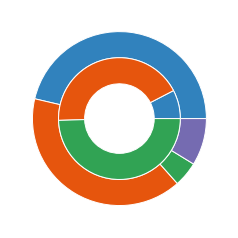

In [22]:
fig, ax = plt.subplots()

size = 0.3
var_vals = [exact_ct, pmsv_xs, rmdr]
tum_vals = [exct_tum_ct, perm_tum_xs, no_match_ct, no_variant_ct]

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(4)*4)
inner_colors = cmap(np.arange(3)*4)

ax.pie(tum_vals, radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(var_vals, radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal")
# plt.show()
plt.savefig('data/donut.svg')

In [23]:
x = np.array(sorted(timings))
x_late = x[6:]

y = [timings[z] for z in x]
y_late = y[6:]
b, m = polyfit(x_late, y_late, 1)

0.8076822691053205 ms/variant


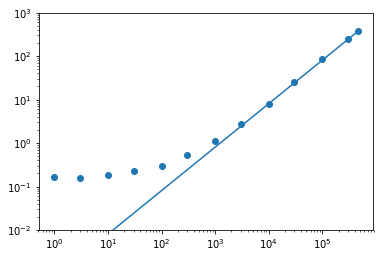

In [24]:
plt.xscale('log')
plt.yscale('log')
plt.ylim((.01,1000))
plt.scatter(sorted(timings), [timings[x] for x in sorted(timings)])
plt.plot(x, m * x, '-')
plt.savefig('data/scatter.svg')
print('{} ms/variant'.format(m*1000))

In [25]:
match_counts = defaultdict(Counter)
levels = ['A','B','C','D','E']
for tumor, matches in exact_tumor.items():
    match_count = len(matches)
    highest_evidence = 4
    for match in matches:
        v = civic.CACHE[match.v_hash]
        for e in v.evidence:
            if levels.index(e.evidence_level) < highest_evidence:
                highest_evidence = levels.index(e.evidence_level)
    match_counts[match_count][levels[highest_evidence]] += 1        

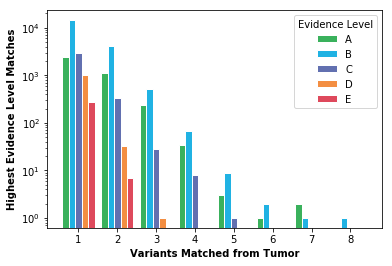

In [26]:
barWidth = 0.25
colors = ['#3ab15c', '#20b2e3', '#6270b0', '#f38e42', '#de495c']

for label in levels:
    idx = levels.index(label)
    counts = [match_counts[x][label] for x in range(1,9)]
    r = np.arange(len(counts))*1.5 + barWidth * idx
    plt.bar(r, counts, color=colors[idx], width=barWidth, edgecolor='white', label=label)
plt.yscale('log')
plt.xlabel('Variants Matched from Tumor', fontweight='bold')
plt.xticks([r * 1.5 + 2 * barWidth for r in range(8)], range(1,9))
plt.ylabel('Highest Evidence Level Matches', fontweight='bold')
plt.legend(title='Evidence Level')
plt.savefig('data/grouped_bar.svg')

In [27]:
mcv = match_counts.values()
summed_counts = Counter()
for c in mcv:
    summed_counts += c

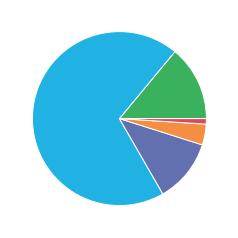

In [28]:
counts = [summed_counts[x] for x in levels]
plt.pie(counts, colors=colors, wedgeprops=dict(edgecolor='w'))
plt.savefig('data/pie.svg')

In [29]:
# Average number of reported variants / tumor
df.groupby('key').count().alt.sum() / len(genie_samples)

6.876070461160556

In [52]:
df.groupby('key').count().alt.median()

4.0

In [30]:
len(civic.get_all_evidence())

6471

In [31]:
len(civic.get_all_variants())

2312

In [32]:
len(civic.get_all_genes())

402

In [59]:
# Percentage of tumors with Exact matches, by top evidence level
matched_tumor_count = sum(summed_counts.values())
for level in sorted(summed_counts):
    print(f"{level}: {round(summed_counts[level] / matched_tumor_count * 100,1)} ({summed_counts[level]})")
print(f"A+B: {round((summed_counts['A'] + summed_counts['B']) / matched_tumor_count * 100,1)} ({(summed_counts['A'] + summed_counts['B'])})")

A: 14.0 (3852)
B: 69.3 (19098)
C: 11.8 (3248)
D: 3.9 (1066)
E: 1.0 (281)
A+B: 83.3 (22950)


In [47]:
# Number of matched tumors
print(matched_tumor_count)

27545


In [34]:
# Percentage of all tumors, by top evidence level
for level in sorted(summed_counts):
    print(f"{level}: {summed_counts[level] / genie_samples_ct * 100}")

A: 6.480811615660278
B: 32.13150058044653
C: 5.464609586621128
D: 1.7934956340326733
E: 0.4727694870198698


In [50]:
# Percentage of tumors with Tier I evidence, exact match to variant
summed_counts_tier_I = sum([summed_counts[x] for x in ['A', 'B']])
print(f"{summed_counts_tier_I / genie_samples_ct * 100} ({summed_counts_tier_I})")

38.6123121961068 (22950)


In [54]:
# Percentage of tumors with N variant Exact matches
not_exact_tum_count = genie_samples_ct - exct_tum_ct
print(f"0: {round(not_exact_tum_count / genie_samples_ct * 100,1)} ({not_exact_tum_count})")
for i in range(1,9):
    print(f"{i}: {round(sum(match_counts[i].values()) / genie_samples_ct * 100,1)} ({sum(match_counts[i].values())})")

0: 53.7 (31892)
1: 35.4 (21026)
2: 9.4 (5592)
3: 1.3 (796)
4: 0.2 (111)
5: 0.0 (13)
6: 0.0 (3)
7: 0.0 (3)
8: 0.0 (1)


In [57]:
# Percentage of variants with matches by search strategy
print(f"exact: {exact_ct / full_ct * 100} ({exact_ct})")
print(f"any: {pmsv_xs / full_ct * 100} ({pmsv_xs})")
print(f"sum: {(exact_ct + pmsv_xs) / full_ct *100} ({(exact_ct + pmsv_xs)})")

exact: 7.602515005541352 (34642)
any: 42.871188263307474 (195349)
sum: 50.47370326884882 (229991)


In [58]:
# Percentage of tumors with matches by search strategy
print(f"exact: {exct_tum_ct / genie_samples_ct * 100} ({exct_tum_ct})")
print(f"any: {perm_tum_xs / genie_samples_ct * 100} ({perm_tum_xs})")
print(f"sum: {(exct_tum_ct + perm_tum_xs) / genie_samples_ct * 100} ({(exct_tum_ct + perm_tum_xs)})")

exact: 46.34318690378048 (27545)
any: 40.25270454430741 (23925)
sum: 86.5958914480879 (51470)


In [46]:
# Percentage of tumors with no variants
print(f"No variants: {no_variant_ct / genie_samples_ct * 100} ({no_variant_ct})")

No variants: 8.748759190403284 (5200)
